# Classifying Post Translational Modifications with scikit-learn
## Sean Landry
## April 30, 2018
## Graduate final project, csci-e29, Python for Data Science
## TF Name: Alan Xie (previously Phil Lodine)


![title](images/title-slide.png)

![staff](images/staff-slide.png)



![abstract](images/abstract-slide.png)

![libraries](images/libraries-datasets-slide.png)

![ptm](images/ptm-slide.png)

![worklfow](images/workflow.png)

In [1]:
import pandas as pd
import wikipedia ## pip install wikipedia
import pandas as pd ## conda install pandas
import numpy as np
from multiprocessing import Pool
import pubchempy as pcp ## pip install pubchempy
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split ## conda install scikit-learn
from sklearn.metrics import accuracy_score

## Feature Engineering

1. helper functions
2. load the datasets
3. extract AA positions, label, sample, and concat
4. retrieve data from wikipedia and pubchem
5. prepare data for models (one hot encoding, train, test, split, etc...)

### 1.  Helper Functions

In [2]:
## some helper functions for feature engineering
def parse_aa_positions(df):
    """Parse each position of an amino acid sequence.
    
    Args:
        df (pd.DataFrame):  Accepts and pandas dataframe with the column "SITE_+/-7_AA".  The string in each
                            row of the column "SITE_+/-7_AA" is expected to be in the format "DkSELVQkAkLAEQA".
        
    Returns:
        features (pd.DataFrame):  The original dataframe with additional columns for each amino acid position. 
                                  The position columns will be labeled p1 --> pn for n number of positions.
    
    """
    features = df.copy()
    
    sites = ["p" + str(i) for i in range(len(features["SITE_+/-7_AA"].iloc[0]))]
    
    sites_df = pd.DataFrame(features["SITE_+/-7_AA"].apply(lambda x: list(x.upper())).values.tolist(), columns=sites)
    sites_df["ptm-aa"] = sites_df["p7"]
    
    features = features.join(sites_df)
    
    return features

def retrieve_wiki_aa_table(page_name, table_int):
    """Retrieve a table from a wikipedia page.
    
    Args:
        page_name (str):  Name of the page, e.g. 'Amino acid'.
        table_int (int):  Number of table on the page, e.g. 2.
    
    Returns:
        pd.DataFrame: The table as a pandas dataframe.
    
    """
    p = wikipedia.page(page_name)
    all_tables = pd.read_html(p.html())
    wiki_aa = all_tables[1]
    return wiki_aa.loc[1:,:].rename(columns = wiki_aa.loc[0,:])

def retrieve_pcp_compound(aminos, 
                          properties=["atom_stereo_count", 
                                      "complexity", 
                                      "rotatable_bond_count", 
                                      "tspa", "xlogp"]):
    """Query pubchem and retrieve chemical properties for a list of amino acids.
    
    Args:
        aminos (list):  A list of amino acid names, e.g. ['arginine', 'alanine', etc..].
        properties (list):  A list of properties to retrieves, [default: ["atom_stereo_count", "complexity", "rotatable_bond_count", "tspa", "xlogp"]]
    
    Returns:
    pd.DataFrame:  A pandas dataframe with amino acids and their properties.
    
    """
    pub_aa = []
    for aa in aminos:
    
        if aa != "Glycine":
            pcp_name = "L-" + aa ## e.g. "L-Arginine"
        compound = pcp.get_compounds(pcp_name, "name", as_dataframe=True)
        compound["Amino acid"] = aa
        compound["pcp-name"] = pcp_name
        pub_aa.append(compound)
    
    pub_aa = pd.concat(pub_aa)
    return pub_aa.filter(items= properties + ["Amino acid", "pcp-name"])



def parallelize_dataframe(df, func, num_partitions = 7, num_cores = 7):
    """Apply a function to a dataframe in parallel.
    
    Reference --> http://www.racketracer.com/2016/07/06/pandas-in-parallel/
 
    Args:
        df (pd.DataFrame):  The dataframe to which the function should be applied.
        func (function):  The function to apply to each partition.
        num_paritions (int):  How many times to split the dataframe.
        num_cores (int):  The number of cores to use.
        
    Returns:
        pandas.DataFrame:  The processed dataframe.
    """
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df


def apply_features(x, cname):
    """Extract features for an amino acid from a dataframe named 'aa_features_slim'
    
    Important --> this function requires a global variable 'aa_features_slim', which is a
    dataframe containing the desired amino acid properties.
    
    Args:
        x (str):  The amino acid one letter code, e.g. "W".
        cname (str): The name of column from which 'x' originated, e.g. "p1".
        
    Returns:
        pd.DataFrame:  A dataframe of features for the amino acid with columns named with the 'cname',
                       e.g. "p14-Side chain class", "p14-Side chain polarity[136]", etc...
    
    """
    features = aa_features_slim[aa_features_slim["1-letter[136]"] == x].drop(columns = "1-letter[136]")
    if features.shape[0] == 0:
        features = pd.concat([features ,pd.DataFrame(np.nan, index=[0], columns=features.columns)])
    names = {c:cname + "-" + c for c in features.columns}
    features = features.rename(index = str,columns = names)
    return features
    

def parallel_apply_features(df):
    """Apply the 'apply_features" function to a dataframe in parallel,
    
    Args:
        df (pandas.DataFrame):  The dataframe to be proccessed.
        
    Returns:
        pandas.DataFrame:  The processed dataframe.
    
    """
    ptm_pos = []
    for pos in df.loc[:, "p0":"p14"].columns:
        ptm_new = df[pos].apply(lambda x: apply_features(x, pos))
        ptm_new = pd.concat(ptm_new.tolist())
        ptm_new = ptm_new.reset_index().drop(columns = "index")
        ptm_pos.append(ptm_new)
    return pd.concat(ptm_pos, axis = 1)


def find_smallest_df(df_list):
    """Return the number of rows from the smallest dataframe.
    
    Args:
        df_list (list):  A list of pandas DataFrames.
        
    Returns:
        smallest (int):  The number of rows from the smallest dataframe.
    """
    smallest = 0
    for d in df_list:
        if smallest == 0:
            smallest = d.shape[0]
        if d.shape[0] < smallest:
            smallest = d.shape[0]
    return smallest


def subset_dfs(df_list, smallest, random_state = 1234):
    """Subset all dataframes provided as a list using sampling.
    
    Args:
        df_list (list):  A list of pandas DataFrames to subset.
        smallest (int):  The number of rows to sample.
        random_state(int):  The random state for sampling, [default: 1234].
        
    Returns:
        all_subs (list):  A list of new sampled dataframes.
    
    """
    all_subs = []

    for d in df_list:
        if d.shape[0] != smallest:
            all_subs.append(d.sample(n = smallest, random_state = random_state))
        else:
            all_subs.append(d)
    return all_subs


### 2. Loading the datasets

In [3]:
acet = pd.read_csv("Acetylation_site_dataset", sep = "\t",  header = 2)
print("Acetylation: ", acet.shape)
#acet.head()

phos = pd.read_csv("Phosphorylation_site_dataset", sep = "\t",  header = 2)
#phos.head()
print("Phosphorylation: ", phos.shape)

ubi = pd.read_csv("Ubiquitination_site_dataset", sep = "\t",  header = 2)
#ubi.head()
print("Ubiquitination ", ubi.shape)

meth = pd.read_csv("Methylation_site_dataset", sep = "\t",  header = 2)
#meth.head()
print("Methylation: ", meth.shape)

sumo = pd.read_csv("Sumoylation_site_dataset", sep = "\t",  header = 2)
#sumo.head()
print("Sumoylation: ", sumo.shape)

oglc = pd.read_csv("O-GlcNAc_site_dataset", sep = "\t",  header = 2)
#oglc.head()
print("O-GlcNAc: ", oglc.shape)

ogal = pd.read_csv("O-GalNAc_site_dataset", sep = "\t",  header = 2)
print("O-GalNAc: ", ogal.shape)
#ogal.head()

Acetylation:  (46540, 14)
Phosphorylation:  (363255, 14)
Ubiquitination  (70338, 14)
Methylation:  (19742, 14)
Sumoylation:  (7095, 14)
O-GlcNAc:  (1583, 14)
O-GalNAc:  (2122, 14)


/home/slandry/miniconda3/envs/e29/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
phos.head()

,GENE,PROTEIN,ACC_ID,HU_CHR_LOC,MOD_RSD,SITE_GRP_ID,ORGANISM,MW_kD,DOMAIN,SITE_+/-7_AA,LT_LIT,MS_LIT,MS_CST,CST_CAT#
0,1110035H17Rik,1110035H17Rik,Q9CTA4,7|7,S10-p,7231581,mouse,24.31,NaN,RPPPGSRstVAQSPP,NaN,1.0,NaN,NaN
1,1110035H17Rik,1110035H17Rik,Q9CTA4,7|7,T11-p,7231583,mouse,24.31,NaN,PPPGSRstVAQSPPQ,NaN,1.0,NaN,NaN
2,YWHAB,14-3-3 beta,P31946,20q13.12,T2-p,15718712,human,28.08,NaN,______MtMDksELV,NaN,3.0,1.0,NaN
3,Ywhab,14-3-3 beta,Q9CQV8,2|2 H3,T2-p,15718712,mouse,28.09,NaN,______MtMDksELV,NaN,2.0,NaN,NaN
4,YWHAB,14-3-3 beta,P31946,20q13.12,S6-p,15718709,human,28.08,NaN,__MtMDksELVQkAk,NaN,7.0,NaN,NaN


### 3. Extract AA positions, label, sample, and concat

In [5]:
## parse amino acid positions and label ptm types
acet_f = parse_aa_positions(acet)
acet_f['ptm-type'] = "acetylation"
phos_f = parse_aa_positions(phos)
phos_f['ptm-type'] = "phosphorylation"
meth_f = parse_aa_positions(meth)
meth_f['ptm-type'] = "methylation"
ubi_f = parse_aa_positions(ubi)
ubi_f['ptm-type'] = "ubiquitination"
sumo_f = parse_aa_positions(sumo)
sumo_f['ptm-type'] = "sumoylation"
oglc_f = parse_aa_positions(oglc)
oglc_f['ptm-type'] = "O-GlcNAc"
ogal_f = parse_aa_positions(ogal)
ogal_f['ptm-type'] = "O-GalNAc"

all_ptms_list = [acet_f, phos_f, meth_f, ubi_f, sumo_f, oglc_f, ogal_f]

## find smallest df
smallest = find_smallest_df(all_ptms_list)

## subset dfs
all_ptms_sub = subset_dfs(all_ptms_list, smallest, random_state = 1234)

## concat all dfs together
all_ptms = pd.concat(all_ptms_sub)

## drop all duplicate sequences, may observe many types of PTM on same sequence
all_ptms = all_ptms.drop_duplicates(subset=["SITE_+/-7_AA"])

## get rid of some columns
all_ptms = all_ptms.loc[:, "ORGANISM":"ptm-type"].drop(columns = ["DOMAIN","SITE_+/-7_AA","LT_LIT","MS_LIT","MS_CST","CST_CAT#"])

print(all_ptms.shape)
all_ptms.head()

(10733, 19)


,ORGANISM,MW_kD,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,ptm-aa,ptm-type
29751,rat,152.82,G,G,G,G,G,G,G,K,I,R,T,R,R,C,H,K,acetylation
2458,human,21.63,V,G,G,P,G,S,G,K,G,T,Q,C,E,K,I,K,acetylation
21722,human,118.07,E,Y,E,D,S,S,T,K,P,P,K,S,R,R,K,K,acetylation
32893,human,37.92,Q,V,W,H,F,L,G,K,_,_,_,_,_,_,_,K,acetylation
35426,human,58.97,P,C,K,I,C,G,D,K,S,S,G,I,H,Y,G,K,acetylation


In [6]:
all_ptms.shape

(10733, 19)

### 4. Retrieve data from wikipedia and pubchem

The following table can be found on wikipedia.  It contains the amino acids and some physiochemical properties.  The features from this table are extracted an mapped to each positions of the 15 amino acid sequences in the datasets.

https://en.wikipedia.org/wiki/Amino_acid

![wiki-table](images/wikipedia-table.png)

In [7]:
## grab table from wikipedia
wiki_aa_df = retrieve_wiki_aa_table("Amino acid", 1)

## query pubchem for more features
pcp_aa_df = retrieve_pcp_compound(wiki_aa_df["Amino acid"])

## merge wikipedia table and pubchem
aa_features = wiki_aa_df.merge(pcp_aa_df, on="Amino acid")

## drop some columns
aa_features_slim = aa_features.drop(columns=["Amino acid", "3-letter[136]", "Coding in the Standard Genetic Code", "pcp-name", "Absorbance λmax(nm)[138]", "ε at λmax (mM−1 cm−1)[138]"])

## convert numeric features to float
aa_features_slim["Hydropathyindex[137]"] = aa_features_slim["Hydropathyindex[137]"].apply(lambda x: x.replace("−", "-")).astype("float")
aa_features_slim["MW (weight)"] = aa_features_slim["MW (weight)"].astype("float")
aa_features_slim["Occurrence in proteins (%)[139]"] = aa_features_slim["Occurrence in proteins (%)[139]"].astype("float")

aa_features_slim.head()

,1-letter[136],Side chain class,Side chain polarity[136],Side chain charge (pH 7.4)[136],Hydropathyindex[137],MW (weight),Occurrence in proteins (%)[139],atom_stereo_count,complexity,rotatable_bond_count,xlogp
0,A,aliphatic,nonpolar,neutral,1.8,89.094,8.76,1,61.8,1,-3.0
1,R,basic,basic polar,positive,-4.5,174.203,5.78,1,176.0,5,-4.2
2,N,amide,polar,neutral,-3.5,132.119,3.93,1,134.0,3,-3.4
3,D,acid,acidic polar,negative,-3.5,133.104,5.49,1,133.0,3,-2.8
4,C,sulfur-containing,nonpolar,neutral,2.5,121.154,1.38,1,75.3,2,-2.5


In [8]:
## for testing
#ptm_test = ptm_test.iloc[0:5, :].reset_index()

In [9]:
%%time
ptms = all_ptms.copy().reset_index().drop(columns = ["index"])

## exract amino acid properties/features for each position
ptm_features = parallelize_dataframe(ptms, parallel_apply_features)

## fill numerical NaN values with mean
ptm_features = ptm_features.fillna(ptm_features.mean())

## join wiki and pubchem features with phosphosite features
ptm_features = ptms.join(ptm_features.reset_index()).drop(columns=["index"])

CPU times: user 2.5 s, sys: 105 ms, total: 2.6 s
Wall time: 1min 24s


In [10]:
ptm_features.head()

,ORGANISM,MW_kD,p0,p1,p2,p3,p4,p5,p6,p7,...,p14-Side chain class,p14-Side chain polarity[136],p14-Side chain charge (pH 7.4)[136],p14-Hydropathyindex[137],p14-MW (weight),p14-Occurrence in proteins (%)[139],p14-atom_stereo_count,p14-complexity,p14-rotatable_bond_count,p14-xlogp
0,rat,152.82,G,G,G,G,G,G,G,K,...,basic aromatic,basic polar,positive(10%)neutral(90%),-3.200000,155.15600,2.260000,1.0000,151.00000,3.000000,-3.200000
1,human,21.63,V,G,G,P,G,S,G,K,...,aliphatic,nonpolar,neutral,4.500000,131.17500,5.490000,2.0000,103.00000,3.000000,-1.700000
2,human,118.07,E,Y,E,D,S,S,T,K,...,basic,basic polar,positive,-3.900000,146.18900,5.190000,1.0000,106.00000,5.000000,-3.000000
3,human,37.92,Q,V,W,H,F,L,G,K,...,NaN,NaN,NaN,-0.675092,128.09529,5.926246,1.1019,115.76892,2.961433,-2.819227
4,human,58.97,P,C,K,I,C,G,D,K,...,aliphatic,nonpolar,neutral,-0.400000,75.06700,7.030000,1.0000,146.00000,4.000000,-3.100000


In [11]:
## showing features generated for an amino acid position
aa_pos = "p0"
p0 =[]
for c in ptm_features.columns:
    if aa_pos in c:
        p0.append(c)
            
ptm_features.loc[0:5, p0]

,p0,p0-Side chain class,p0-Side chain polarity[136],p0-Side chain charge (pH 7.4)[136],p0-Hydropathyindex[137],p0-MW (weight),p0-Occurrence in proteins (%)[139],p0-atom_stereo_count,p0-complexity,p0-rotatable_bond_count,p0-xlogp
0,G,aliphatic,nonpolar,neutral,-0.4,75.067,7.03,1.0,146.0,4.0,-3.1
1,V,aliphatic,nonpolar,neutral,4.2,117.148,6.73,1.0,90.4,2.0,-2.3
2,E,acid,acidic polar,negative,-3.5,147.131,6.32,1.0,145.0,4.0,-3.7
3,Q,amide,polar,neutral,-3.5,146.146,3.90,1.0,146.0,4.0,-3.1
4,P,cyclic,nonpolar,neutral,-1.6,115.132,5.02,1.0,103.0,1.0,-2.5
5,N,amide,polar,neutral,-3.5,132.119,3.93,1.0,134.0,3.0,-3.4


In [12]:
## break point
ptm_features.to_csv("ptm_features.csv")

In [13]:
ptm_features = pd.read_csv("ptm_features.csv", index_col=0)

In [14]:
ptm_features.head()

,ORGANISM,MW_kD,p0,p1,p2,p3,p4,p5,p6,p7,...,p14-Side chain class,p14-Side chain polarity[136],p14-Side chain charge (pH 7.4)[136],p14-Hydropathyindex[137],p14-MW (weight),p14-Occurrence in proteins (%)[139],p14-atom_stereo_count,p14-complexity,p14-rotatable_bond_count,p14-xlogp
0,rat,152.82,G,G,G,G,G,G,G,K,...,basic aromatic,basic polar,positive(10%)neutral(90%),-3.200000,155.15600,2.260000,1.0000,151.00000,3.000000,-3.200000
1,human,21.63,V,G,G,P,G,S,G,K,...,aliphatic,nonpolar,neutral,4.500000,131.17500,5.490000,2.0000,103.00000,3.000000,-1.700000
2,human,118.07,E,Y,E,D,S,S,T,K,...,basic,basic polar,positive,-3.900000,146.18900,5.190000,1.0000,106.00000,5.000000,-3.000000
3,human,37.92,Q,V,W,H,F,L,G,K,...,NaN,NaN,NaN,-0.675092,128.09529,5.926246,1.1019,115.76892,2.961433,-2.819227
4,human,58.97,P,C,K,I,C,G,D,K,...,aliphatic,nonpolar,neutral,-0.400000,75.06700,7.030000,1.0000,146.00000,4.000000,-3.100000


In [15]:
## full feature list

categorical = ['ORGANISM',
               'p0',
               'p1',
               'p2',
               'p3',
               'p4',
               'p5',
               'p6',
               'p7',
               'p8',
               'p9',
               'p10',
               'p11',
               'p12',
               'p13',
               'p14',
               'ptm-aa',
               'ptm-type',
               'p0-Side chain class',
               'p0-Side chain polarity[136]',
               'p0-Side chain charge (pH 7.4)[136]',
               'p1-Side chain class',
               'p1-Side chain polarity[136]',
               'p1-Side chain charge (pH 7.4)[136]',
               'p2-Side chain class',
               'p2-Side chain polarity[136]',
               'p2-Side chain charge (pH 7.4)[136]',
               'p3-Side chain class',
               'p3-Side chain polarity[136]',
               'p3-Side chain charge (pH 7.4)[136]',
               'p4-Side chain class',
               'p4-Side chain polarity[136]',
               'p4-Side chain charge (pH 7.4)[136]',
               'p5-Side chain class',
               'p5-Side chain polarity[136]',
               'p5-Side chain charge (pH 7.4)[136]',
               'p6-Side chain class',
               'p6-Side chain polarity[136]',
               'p6-Side chain charge (pH 7.4)[136]',
               'p7-Side chain class',
               'p7-Side chain polarity[136]',
               'p7-Side chain charge (pH 7.4)[136]',
               'p8-Side chain class',
               'p8-Side chain polarity[136]',
               'p8-Side chain charge (pH 7.4)[136]',
               'p9-Side chain class',
               'p9-Side chain polarity[136]',
               'p9-Side chain charge (pH 7.4)[136]',
               'p10-Side chain class',
               'p10-Side chain polarity[136]',
               'p10-Side chain charge (pH 7.4)[136]',
               'p11-Side chain class',
               'p11-Side chain polarity[136]',
               'p11-Side chain charge (pH 7.4)[136]',
               'p12-Side chain class',
               'p12-Side chain polarity[136]',
               'p12-Side chain charge (pH 7.4)[136]',
               'p13-Side chain class',
               'p13-Side chain polarity[136]',
               'p13-Side chain charge (pH 7.4)[136]',
               'p14-Side chain class',
               'p14-Side chain polarity[136]',
               'p14-Side chain charge (pH 7.4)[136]']

numerical = ['MW_kD',
 'p0-Hydropathyindex[137]',
 'p0-MW (weight)',
 'p0-Occurrence in proteins (%)[139]',
 'p0-atom_stereo_count',
 'p0-complexity',
 'p0-rotatable_bond_count',
 'p0-xlogp',
 'p1-Hydropathyindex[137]',
 'p1-MW (weight)',
 'p1-Occurrence in proteins (%)[139]',
 'p1-atom_stereo_count',
 'p1-complexity',
 'p1-rotatable_bond_count',
 'p1-xlogp',
 'p2-Hydropathyindex[137]',
 'p2-MW (weight)',
 'p2-Occurrence in proteins (%)[139]',
 'p2-atom_stereo_count',
 'p2-complexity',
 'p2-rotatable_bond_count',
 'p2-xlogp',
 'p3-Hydropathyindex[137]',
 'p3-MW (weight)',
 'p3-Occurrence in proteins (%)[139]',
 'p3-atom_stereo_count',
 'p3-complexity',
 'p3-rotatable_bond_count',
 'p3-xlogp',
 'p4-Hydropathyindex[137]',
 'p4-MW (weight)',
 'p4-Occurrence in proteins (%)[139]',
 'p4-atom_stereo_count',
 'p4-complexity',
 'p4-rotatable_bond_count',
 'p4-xlogp',
 'p5-Hydropathyindex[137]',
 'p5-MW (weight)',
 'p5-Occurrence in proteins (%)[139]',
 'p5-atom_stereo_count',
 'p5-complexity',
 'p5-rotatable_bond_count',
 'p5-xlogp',
 'p6-Hydropathyindex[137]',
 'p6-MW (weight)',
 'p6-Occurrence in proteins (%)[139]',
 'p6-atom_stereo_count',
 'p6-complexity',
 'p6-rotatable_bond_count',
 'p6-xlogp',
 'p7-Hydropathyindex[137]',
 'p7-MW (weight)',
 'p7-Occurrence in proteins (%)[139]',
 'p7-atom_stereo_count',
 'p7-complexity',
 'p7-rotatable_bond_count',
 'p7-xlogp',
 'p8-Hydropathyindex[137]',
 'p8-MW (weight)',
 'p8-Occurrence in proteins (%)[139]',
 'p8-atom_stereo_count',
 'p8-complexity',
 'p8-rotatable_bond_count',
 'p8-xlogp',
 'p9-Hydropathyindex[137]',
 'p9-MW (weight)',
 'p9-Occurrence in proteins (%)[139]',
 'p9-atom_stereo_count',
 'p9-complexity',
 'p9-rotatable_bond_count',
 'p9-xlogp',
 'p10-Hydropathyindex[137]',
 'p10-MW (weight)',
 'p10-Occurrence in proteins (%)[139]',
 'p10-atom_stereo_count',
 'p10-complexity',
 'p10-rotatable_bond_count',
 'p10-xlogp',
 'p11-Hydropathyindex[137]',
 'p11-MW (weight)',
 'p11-Occurrence in proteins (%)[139]',
 'p11-atom_stereo_count',
 'p11-complexity',
 'p11-rotatable_bond_count',
 'p11-xlogp',
 'p12-Hydropathyindex[137]',
 'p12-MW (weight)',
 'p12-Occurrence in proteins (%)[139]',
 'p12-atom_stereo_count',
 'p12-complexity',
 'p12-rotatable_bond_count',
 'p12-xlogp',
 'p13-Hydropathyindex[137]',
 'p13-MW (weight)',
 'p13-Occurrence in proteins (%)[139]',
 'p13-atom_stereo_count',
 'p13-complexity',
 'p13-rotatable_bond_count',
 'p13-xlogp',
 'p14-Hydropathyindex[137]',
 'p14-MW (weight)',
 'p14-Occurrence in proteins (%)[139]',
 'p14-atom_stereo_count',
 'p14-complexity',
 'p14-rotatable_bond_count',
 'p14-xlogp']

### 5. Prepare data for models (one hot encoding, train, test, split, etc...)

In [16]:
## targets
ptm_model_target = ptm_features["ptm-type"]

## apply one hot encoding to categorical features
ptm_categorical_onehot = pd.get_dummies(ptm_features[categorical].drop(columns = "ptm-type"))

## join one hot encoded variables with numerical features
ptm_model_features = ptm_categorical_onehot.join(ptm_features[numerical])

## apply standard scalar to features to bring mean to 0 and variance to 1,
scaler = StandardScaler()
ptm_model_features_scaled = scaler.fit_transform(ptm_model_features)

## split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(ptm_model_features_scaled, ptm_model_target, test_size=.4, random_state=42)

In [17]:
ptm_model_features_scaled.shape

(10733, 671)

## The Models

1. PCA
2. PCA & SVC pipeline
3. RandomForestClassifier

### PCA

First, principal component analysis is applied in an effort to reduce the number of dimensions in the dataset.  The 'explained variance' vs '# of components' is plotted to utilize the 'elbow' rule to estimate the number of components to include in classification.

In [18]:
## Reference --> Lecture April 11b,2018 PCA
pca = PCA()

# Fitting the model with features
pca.fit(ptm_model_features_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [19]:
# Extracting 
print("Principal components:\n",pca.components_,"\n")
print("Variance explained:\n",pca.explained_variance_)

Principal components:
 [[-1.08501867e-03  3.54796262e-03  1.53229443e-03 ... -2.87663005e-02
  -3.83554235e-02  1.06807874e-03]
 [ 2.35206785e-03  9.94798968e-04  4.55457522e-03 ... -5.30856355e-02
  -5.19784853e-02  2.74313405e-02]
 [ 6.55749806e-03  7.40724977e-03  5.51134362e-03 ...  2.89558758e-02
   4.74663183e-02 -3.28343255e-02]
 ...
 [-0.00000000e+00 -4.80266549e-17 -1.48699465e-16 ... -2.16372505e-03
  -3.16395865e-02 -2.66992182e-02]
 [-0.00000000e+00 -1.40429008e-17  2.74841868e-17 ... -3.77478130e-03
  -2.30621427e-02 -8.10579637e-03]
 [ 0.00000000e+00  1.18828558e-16  6.99895173e-18 ... -8.91178400e-03
   2.02117741e-02  2.07657636e-02]] 

Variance explained:
 [1.56397634e+01 1.04869634e+01 9.23936381e+00 8.73431981e+00
 8.41826525e+00 8.07555237e+00 7.93111874e+00 7.88316326e+00
 7.70968378e+00 7.62221752e+00 7.51376032e+00 7.44111713e+00
 7.36822728e+00 7.19318070e+00 7.08000085e+00 6.25698872e+00
 5.69454244e+00 5.49135035e+00 5.36353453e+00 5.20692914e+00
 5.12711804e+

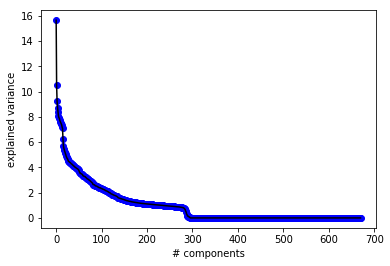

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

b = pca.explained_variance_
a = list(range(len(ptm_model_features.columns)))
plt.plot(a,b, "bo",a,b,"k")
plt.xlabel("# components")
plt.ylabel("explained variance")

## plot explained variance vs number of components
plt.show()

Based on the plot above, 100, 300, and all of the components were selected as potential values for training a classifier.

### PCA & SVC Pipeline

The Pipeline feature of sklearn is used in conjuction with the GridSearchCV capability to construct a PCA, SVC classifier.  The first step in the pipeline is PCA followed by SVC.  Parameters included in the grid search are the values for the number of components included in the PCA step ranging from 100 to 671.  The grid search uses a five fold cross validation splitting strategy.

In [21]:
%%time

## References:
##http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV
##http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
##http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-grid-search-text-feature-extraction-py

parameters = {
    'reduce_dim__n_components': [len(ptm_model_features.columns), 100, 300]
}

pipe =Pipeline( [
    ("reduce_dim", PCA()),
    ("clf_svc,", SVC())
])
grid_search = GridSearchCV(pipe, parameters, n_jobs=-1, verbose=1, cv=5)

grid_search.fit(X_train, y_train)

print("Best parameters", grid_search.best_params_)


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.6min finished


Best parameters {'reduce_dim__n_components': 671}
CPU times: user 43.8 s, sys: 209 ms, total: 44 s
Wall time: 3min 20s


#### PCA & SVC Pipeline Classification Report

In [22]:
%time
pca_svc_predictions = grid_search.predict(X_test)
print(classification_report(y_test, pca_svc_predictions))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs
                 precision    recall  f1-score   support

       O-GalNAc       0.68      0.83      0.75       614
       O-GlcNAc       0.83      0.64      0.72       609
    acetylation       0.58      0.48      0.52       665
    methylation       0.98      0.73      0.84       615
phosphorylation       0.67      0.69      0.68       637
    sumoylation       0.63      0.60      0.61       544
 ubiquitination       0.45      0.67      0.54       610

    avg / total       0.69      0.66      0.66      4294



#### PCA & SVC Pipeline Confusion Matrix

In [43]:
## confusion matrix
pca_svc_cm = confusion_matrix(pca_svc_predictions, y_test)

pca_svc_cm_df = pd.DataFrame(pca_svc_cm, columns = np.sort(ptm_model_target.unique()), index = np.sort(ptm_model_target.unique()))
print("Confusion Matrix")
pca_svc_cm_df

Confusion Matrix


,O-GalNAc,O-GlcNAc,acetylation,methylation,phosphorylation,sumoylation,ubiquitination
O-GalNAc,507,102,0,0,134,0,0
O-GlcNAc,18,390,0,0,63,0,0
acetylation,0,0,316,49,0,63,119
methylation,0,0,5,446,0,2,0
phosphorylation,89,117,5,4,440,1,1
sumoylation,0,0,74,36,0,324,84
ubiquitination,0,0,265,80,0,154,406


### PCA, SVC pipeine summary

The grid search determined the best performance was achieved using all 671 components

The classification report reveals some promising f1-scores for certian types of PTMs while other are underwhelming.  The top three performers being methylation, O-GalNAc and O-GlcNAc with f1-scores of 0.84, 0.75, and 0.72 respectively.  Ubiquination, acetylation, and sumoylation are the poorest performing with f1-scores of 0.54, 0.52, and 0.61 respectively.  

The confusion matrix presents some interesting patterns.  The false negatives for each type of PTM are typically grouped into 2 to 4 other PTMs but rarely appearing in all 6 other types of PTMs.  For example, acetylation is sometimes wrongly classified as methylation, sumoylation, or ubiquitination, however, never as phosphorylation, O-GlcNAc, or O-GalNAc.  In another example, sumoylation is wronly classified as acetylation methylation, sumoylation, or ubiquitination.  These patterns could infer some sort of relationship between these types of PTMs within the current features space.  One with expertise in this field may be able to make some inferences regarding these patterns.  

### RandomForestClassifier

In the spirit of experminentation, the data is also run through the RandomForestClassifier.  A GridSearchCV is conducted to test different values for the 'min_samples_leaf', 'min_samples_split', 'n_estimators', and 'warm_start' parameters.  The grid search uses a five fold cross validation splitting strategy.

In [27]:
%%time
## http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier

param_grid = {'bootstrap': [True],
 'class_weight': [None],
 'criterion': ['gini'],
 'max_depth': [None],
 'max_features': ['auto'],
 'max_leaf_nodes': [None],
 'min_impurity_decrease': [0.0],
 'min_impurity_split': [None],
 'min_samples_leaf': [1,2,3],
 'min_samples_split': [2,4,8],
 'min_weight_fraction_leaf': [0.0],
 'n_estimators': [160, 320, 640, 1280],
 'n_jobs': [7],
 'oob_score': [False],
 'random_state': [1234],
 'verbose': [0],
 'warm_start': [False, True]}


forest_clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)

forest_clf.fit(X_train, y_train)

print("Best parameters for training set: ", forest_clf.best_params_)
print("Best test score: ", str(forest_clf.best_score_) + " +/- " + str(round(forest_clf.cv_results_["std_test_score"][forest_clf.best_index_], 2)))


Best parameters for training set:  {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1280, 'n_jobs': 7, 'oob_score': False, 'random_state': 1234, 'verbose': 0, 'warm_start': False}
Best test score:  0.6758813480354092 +/- 0.01
CPU times: user 1h 46min 55s, sys: 1min 23s, total: 1h 48min 19s
Wall time: 20min 37s


#### RandomForestClassifier Classification Report

In [28]:
forest_predictions = forest_clf.predict(X_test)

print(classification_report(y_test, forest_predictions))

                 precision    recall  f1-score   support

       O-GalNAc       0.70      0.79      0.75       614
       O-GlcNAc       0.80      0.71      0.75       609
    acetylation       0.61      0.51      0.55       665
    methylation       1.00      0.72      0.84       615
phosphorylation       0.68      0.67      0.68       637
    sumoylation       0.67      0.58      0.62       544
 ubiquitination       0.45      0.71      0.55       610

    avg / total       0.70      0.67      0.68      4294



#### RandomForestClassifier Confusion Matrix

In [41]:
# confusion matrix
forest_cm = confusion_matrix(forest_predictions, y_test)

forest_cm_df = pd.DataFrame(forest_cm, columns = np.sort(ptm_model_target.unique()), index = np.sort(ptm_model_target.unique()))
print("Confusion Matrix")
forest_cm_df

Confusion Matrix


,O-GalNAc,O-GlcNAc,acetylation,methylation,phosphorylation,sumoylation,ubiquitination
O-GalNAc,488,85,0,0,121,0,0
O-GlcNAc,20,435,0,0,91,0,0
acetylation,0,0,337,47,0,57,109
methylation,0,0,2,445,0,0,0
phosphorylation,106,89,0,1,425,0,0
sumoylation,0,0,56,27,0,314,69
ubiquitination,0,0,270,95,0,173,432


In [39]:
l = ptm_model_target.unique()
np.sort(l)

array(['O-GalNAc', 'O-GlcNAc', 'acetylation', 'methylation',
       'phosphorylation', 'sumoylation', 'ubiquitination'], dtype=object)

### RandomForestClassifier summary

The grid search revealed the best parameters for the training data set were 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1280, and warm_start': False.  According to the 'n_estimators' parameter, the model built 1280 trees each pass dramatically increasing the run time when compared to the PCA and SVC pipeline.  

The classification report highlights methylation, O-GalNAc, and O-GlcNAc as top performers with f1 scores of 0.84, 0.75, and 0.75 respectively.  The confusion matrix is very similar to the PCA, SVC pipeline.

### Comparing PCA, SVC vs RandomForestClassifier

In [44]:
pca_svc_cm_df

,O-GalNAc,O-GlcNAc,acetylation,methylation,phosphorylation,sumoylation,ubiquitination
O-GalNAc,507,102,0,0,134,0,0
O-GlcNAc,18,390,0,0,63,0,0
acetylation,0,0,316,49,0,63,119
methylation,0,0,5,446,0,2,0
phosphorylation,89,117,5,4,440,1,1
sumoylation,0,0,74,36,0,324,84
ubiquitination,0,0,265,80,0,154,406


In [45]:
forest_cm_df

,O-GalNAc,O-GlcNAc,acetylation,methylation,phosphorylation,sumoylation,ubiquitination
O-GalNAc,488,85,0,0,121,0,0
O-GlcNAc,20,435,0,0,91,0,0
acetylation,0,0,337,47,0,57,109
methylation,0,0,2,445,0,0,0
phosphorylation,106,89,0,1,425,0,0
sumoylation,0,0,56,27,0,314,69
ubiquitination,0,0,270,95,0,173,432


### Comparing PCA, SVC vs RandomForestClassifier

In [22]:
%time
pca_svc_predictions = grid_search.predict(X_test)
print(classification_report(y_test, pca_svc_predictions))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs
                 precision    recall  f1-score   support

       O-GalNAc       0.68      0.83      0.75       614
       O-GlcNAc       0.83      0.64      0.72       609
    acetylation       0.58      0.48      0.52       665
    methylation       0.98      0.73      0.84       615
phosphorylation       0.67      0.69      0.68       637
    sumoylation       0.63      0.60      0.61       544
 ubiquitination       0.45      0.67      0.54       610

    avg / total       0.69      0.66      0.66      4294



In [28]:
forest_predictions = forest_clf.predict(X_test)

print(classification_report(y_test, forest_predictions))

                 precision    recall  f1-score   support

       O-GalNAc       0.70      0.79      0.75       614
       O-GlcNAc       0.80      0.71      0.75       609
    acetylation       0.61      0.51      0.55       665
    methylation       1.00      0.72      0.84       615
phosphorylation       0.68      0.67      0.68       637
    sumoylation       0.67      0.58      0.62       544
 ubiquitination       0.45      0.71      0.55       610

    avg / total       0.70      0.67      0.68      4294



## Next steps

- Assign probabilities to classifications with RandomForestRegressor or Support Vector Regressor (SVC)
- Explore the similarities within the clusters highlighted by the confusion matrix
- Extend feature space beyond amino acid composition to areas such as the proteins responsible for targeting these PTMs

![libraries](images/libraries-datasets-slide.png)

![references](images/references-slide.png)